# Subsetting and retrieval of global sealevel/ssh observation data
If you prefer to interact with a Python script instead, you can convert this notebook to *.py with `jupyter nbconvert --to script subset_retrieve_sealevel_observations.ipynb`.


In [1]:
import os
import glob
import matplotlib.pyplot as plt
import xarray as xr
import dfm_tools as dfmt


To get an overview of the largest publicly available global sealevel observation datasets, we use `dfmt.ssh_catalog_subset()` with the `source` argument. For IOC and GESLA3 we also subset to highlight where they add significantly to the global spatial spatial coverage.

In [2]:
# ssc_catalog_gpd = dfmt.ssh_catalog_subset(source='ssc') # no data, only station locations
gesla_catalog_gpd = dfmt.ssh_catalog_subset(source='gesla3') # requires p-drive connection or download yourself
ioc_catalog_gpd = dfmt.ssh_catalog_subset(source='ioc')
cmems_catalog_gpd = dfmt.ssh_catalog_subset(source='cmems')
uhslc_catalog_gpd = dfmt.ssh_catalog_subset(source='uhslc')
psmsl_gnssir_catalog_gpd = dfmt.ssh_catalog_subset(source='psmsl-gnssir')
rwsddl_catalog_gpd = dfmt.ssh_catalog_subset(source='rwsddl')

# subsetting gesla
bool_ndays = gesla_catalog_gpd["time_ndays"] > 365
bool_country = gesla_catalog_gpd['country'].isin(['CAN','GRL'])
bool_contrib = gesla_catalog_gpd['contributor_abbreviated'].isin(['MEDS',"GLOSS"])
gesla_catalog_gpd_sel = gesla_catalog_gpd.loc[bool_country & bool_contrib & bool_ndays]

# subsetting ioc
bool_ndays = ioc_catalog_gpd["time_ndays"] > 365
bool_country = ioc_catalog_gpd['country'].isin(['RUS','IND'])
ioc_catalog_gpd_sel = ioc_catalog_gpd.loc[bool_ndays & bool_country]


>> reading coastlines: 0.76 sec
>> reading country borders: 0.01 sec


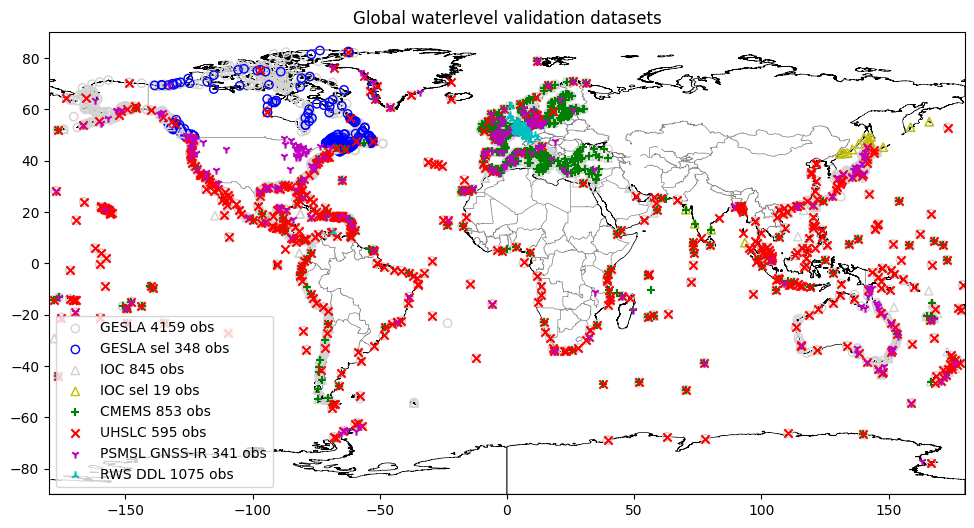

In [3]:
# plot stations
fig,ax = plt.subplots(figsize=(14,6))
gesla_catalog_gpd.geometry.plot(ax=ax, marker="o", color="lightgray", facecolor="none", label=f"GESLA {len(gesla_catalog_gpd)} obs")
gesla_catalog_gpd_sel.geometry.plot(ax=ax, marker="o", color="b", facecolor="none", label=f"GESLA sel {len(gesla_catalog_gpd_sel)} obs")
ioc_catalog_gpd.geometry.plot(ax=ax, marker="^", color="lightgray", facecolor="none", label=f"IOC {len(ioc_catalog_gpd)} obs")
ioc_catalog_gpd_sel.geometry.plot(ax=ax, marker="^", color="y", facecolor="none", label=f"IOC sel {len(ioc_catalog_gpd_sel)} obs")
cmems_catalog_gpd.geometry.plot(ax=ax, marker="+", color="g", label=f"CMEMS {len(cmems_catalog_gpd)} obs")
uhslc_catalog_gpd.geometry.plot(ax=ax, marker="x", color="r", label=f"UHSLC {len(uhslc_catalog_gpd)} obs")
psmsl_gnssir_catalog_gpd.geometry.plot(ax=ax, marker="1", color="m", label=f"PSMSL GNSS-IR {len(psmsl_gnssir_catalog_gpd)} obs")
rwsddl_catalog_gpd.geometry.plot(ax=ax, marker="2", color="c", label=f"RWS DDL {len(rwsddl_catalog_gpd)} obs")

ax.set_xlim(-181,181)
ax.set_ylim(-90,90)
ax.legend(loc=3)
ax.set_title("Global waterlevel validation datasets")
ax.set_xlim(-180,180)
dfmt.plot_coastlines(ax=ax, min_area=1000, linewidth=0.5, zorder=0)
dfmt.plot_borders(ax=ax, zorder=0)


The GTSM-ERA5 dataset contains model output from GTSM forced with ERA5 reanalysis. This can be valuable validation data, although it cannot be considered the same quality as observations. The dataset has a very dense coverage, so these points are visualized in a separate figure.

>> reading coastlines: 1.23 sec
>> reading country borders: 0.01 sec


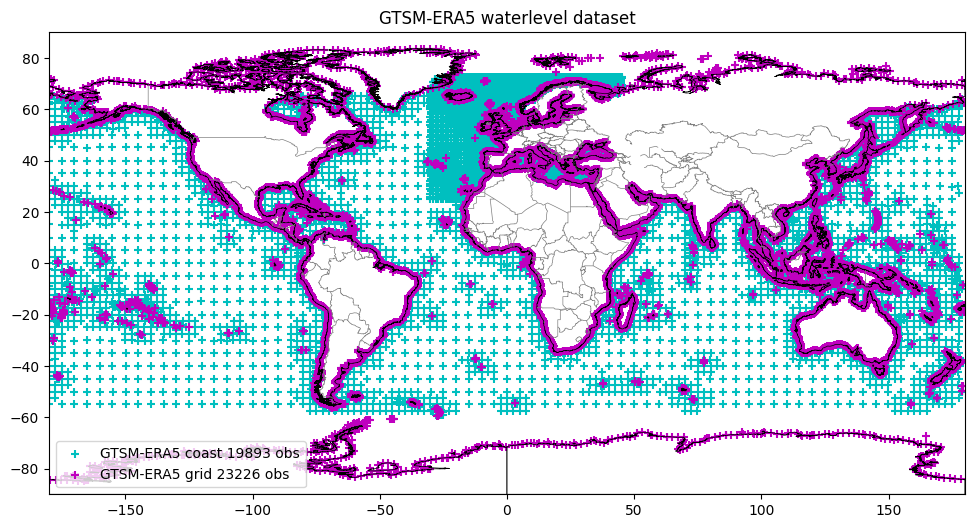

In [4]:
# subsetting gtsm-era5 - coast vs. grid points
gtsm_era5_catalog_gpd = dfmt.ssh_catalog_subset(source='gtsm3-era5-cds')
bool_grid = gtsm_era5_catalog_gpd['station_name_unique'].str.contains('grid')
gtsm_era5_catalog_gpd_coast = gtsm_era5_catalog_gpd.loc[~bool_grid]
gtsm_era5_catalog_gpd_grid = gtsm_era5_catalog_gpd.loc[bool_grid]

# plot GTSM stations
fig,ax = plt.subplots(figsize=(14,6))
gtsm_era5_catalog_gpd_grid.geometry.plot(ax=ax,marker="+", color="c", label=f'GTSM-ERA5 coast {len(gtsm_era5_catalog_gpd_grid)} obs', zorder=-1)
gtsm_era5_catalog_gpd_coast.geometry.plot(ax=ax,marker="+", color="m", label=f'GTSM-ERA5 grid {len(gtsm_era5_catalog_gpd_coast)} obs', zorder=-1)
ax.set_xlim(-181,181)
ax.set_ylim(-90,90)
ax.legend(loc=3)
ax.set_title("GTSM-ERA5 waterlevel dataset")
ax.set_xlim(-180,180)
dfmt.plot_coastlines(ax=ax, min_area=1000, linewidth=0.5, zorder=0)
dfmt.plot_borders(ax=ax, zorder=0)


Next, we will subset all sources in time and space by providing more arguments to `dfmt.ssh_catalog_subset`. The stations with data in this period and area are plotted. 

retrieving psmsl-gnssir time extents for 12 stations: 1 2 3 4 5 6 7 8 9 10 11 12 
>> reading coastlines: 0.55 sec
>> reading country borders: 0.01 sec


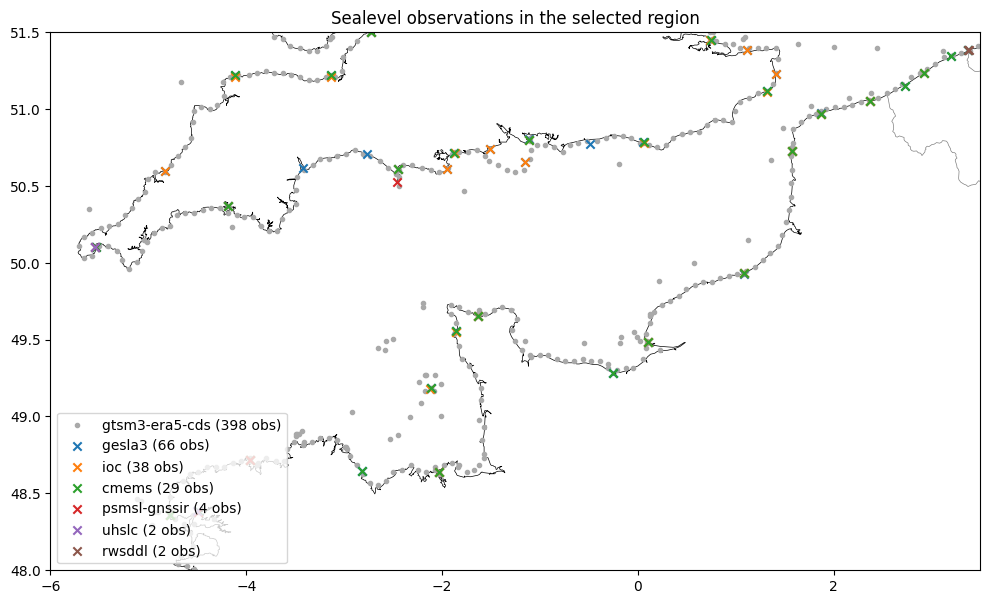

In [5]:
dir_output = "./sealevel_data_subset"
os.makedirs(dir_output, exist_ok=True)

lon_min, lon_max, lat_min, lat_max = -6, 3.5, 48, 51.5 # france
# lon_min, lon_max, lat_min, lat_max = 123, 148, 23, 47 # japan
# lon_min, lon_max, lat_min, lat_max = -20, 40, 25, 72 # europe
time_min, time_max = '2016-01-01','2016-02-01'

subset_kwargs = dict(lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max, 
                     time_min=time_min, time_max=time_max)
gesla_catalog_gpd_sel = dfmt.ssh_catalog_subset(source='gesla3', **subset_kwargs)
ioc_catalog_gpd_sel = dfmt.ssh_catalog_subset(source='ioc', **subset_kwargs)
cmems_catalog_gpd_sel = dfmt.ssh_catalog_subset(source='cmems', **subset_kwargs)
uhslc_catalog_gpd_sel = dfmt.ssh_catalog_subset(source='uhslc', **subset_kwargs)
psmsl_gnssir_catalog_gpd_sel = dfmt.ssh_catalog_subset(source='psmsl-gnssir', **subset_kwargs)
gtsm_era5_catalog_gpd_sel = dfmt.ssh_catalog_subset(source='gtsm3-era5-cds', **subset_kwargs)
# subsetting gtsm-era5 - exclude grid points in the open water
gtsm_era5_catalog_gpd_sel = gtsm_era5_catalog_gpd_sel.loc[~gtsm_era5_catalog_gpd_sel['station_name_unique'].str.contains('grid')]

# TODO: no time subsetting supported for rwsddl
for key in ["time_min", "time_max"]:
    subset_kwargs.pop(key)
rwsddl_catalog_gpd_sel = dfmt.ssh_catalog_subset(source='rwsddl', **subset_kwargs)
subset_gpd_list = [gtsm_era5_catalog_gpd_sel, gesla_catalog_gpd_sel,
                  ioc_catalog_gpd_sel, cmems_catalog_gpd_sel,
                  psmsl_gnssir_catalog_gpd_sel, uhslc_catalog_gpd_sel,
                  rwsddl_catalog_gpd_sel]

# plot stations
fig,ax = plt.subplots(figsize=(12,7))
for subset_gpd in subset_gpd_list:
    if subset_gpd.empty:
        continue
    source = subset_gpd.iloc[0]["source"]
    nstations = len(subset_gpd)
    color = None
    marker = 'x'
    if source == 'gtsm3-era5-cds':
        color = 'darkgray'
        marker = '.'
    subset_gpd.geometry.plot(ax=ax, marker=marker, color=color, label=f"{source} ({nstations} obs)")
ax.legend(loc=3)
ax.set_title("Sealevel observations in the selected region")
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)
dfmt.plot_coastlines(ax=ax, min_area=1000, linewidth=0.5, zorder=0)
dfmt.plot_borders(ax=ax, zorder=0)

The waterlevel timeseries are retrieved with `dfmt.ssh_retrieve_data`. Since GESLA and IOC do not provide additional spatial coverage in this region, these datasets are skipped. The GTSM dataset is also skipped since it contains too much stations and it would overfill the figures.

In [6]:
# retrieve data (for all sources except gesla, ioc and gtsm)
subset_gpd_list_retrieve = [cmems_catalog_gpd_sel,
                            psmsl_gnssir_catalog_gpd_sel,
                            uhslc_catalog_gpd_sel,
                            rwsddl_catalog_gpd_sel]

for subset_gpd in subset_gpd_list_retrieve:
    dfmt.ssh_retrieve_data(subset_gpd, dir_output,
                           time_min=time_min, time_max=time_max)


retrieving data for 29 cmems stations: 1 2 3 4 5 6 7 8 9 10 [NODATA] [NODATA] 11 12 13 [NODATA] [NODATA] 14 15 16 17 18 19 20 21 [NODATA] [NODATA] 22 23 24 25 26 27 28 29 
2 3 4 ving data for 4 psmsl-gnssir stations: 1 
2 trieving data for 2 uhslc stations: 1 
retrieving data for 2 rwsddl stations: 1 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


2 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.19it/s]

[NODATA] 


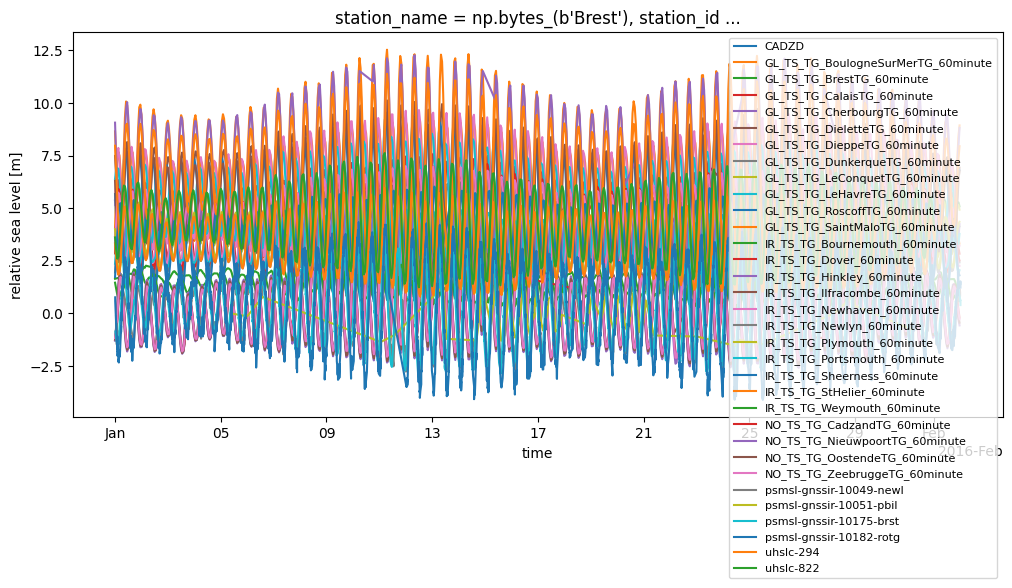

In [7]:
# plot the retrieved datasets
fig,ax = plt.subplots(figsize=(12,5))
file_list = glob.glob(os.path.join(dir_output, "*.nc"))
file_list.sort()
for file_nc in file_list:
    ds = xr.open_dataset(file_nc)
    station_name = os.path.basename(file_nc).strip(".nc")
    ds.waterlevel.plot(ax=ax, label=station_name)
    del ds
ax.legend(loc=1, fontsize=8)


creating overview for 33 files: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 


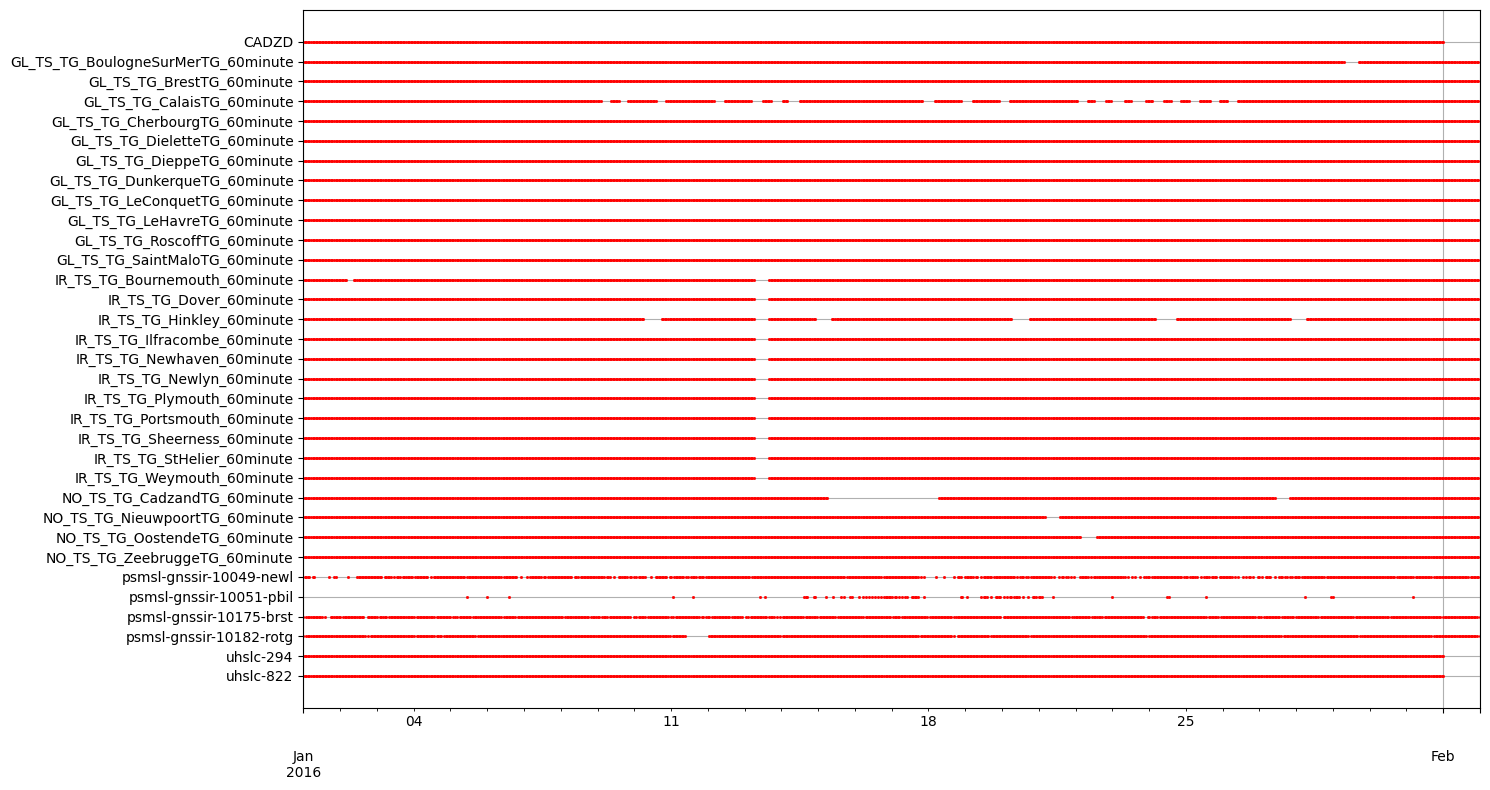

In [8]:
# create overview plot and statistics csv
dfmt.ssh_netcdf_overview(dir_output, perplot=40)
